# Datos completos

## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import matplotlib.dates as mdates
from ruptures import Pelt, KernelCPD
from sklearn.preprocessing import StandardScaler
import gudhi as gd
from ruptures import Pelt
import seaborn as sns

Librerías necesarias para ejecutar este notebook.

## Carga bases de datos

In [2]:
iar_Reservaciones = pd.read_csv('Selected/iar_Reservaciones.csv')
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["aa_h_num_per"] == 0]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["h_tfa_total"] >= 0]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["h_tfa_total"] <= 200000]
iar_Reservaciones = iar_Reservaciones[[col for col in iar_Reservaciones.columns if not col.startswith("aa")]]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones['h_fec_lld_okt'] >= '2019-01-01']
#iar_Reservaciones = iar_Reservaciones[iar_Reservaciones['h_fec_lld_okt'] <= '2020-01-01']
#iar_Reservaciones = iar_Reservaciones.sort_values('h_fec_lld_okt')
#iar_Reservaciones = iar_Reservaciones.set_index('h_fec_lld_okt')
#iar_Reservaciones.index = pd.to_datetime(iar_Reservaciones.index, errors='coerce')

/var/folders/p9/b03xf1dn2n34z0fr_cls9vz00000gp/T/ipykernel_62848/1100925355.py:1: DtypeWarning: Columns (22,28) have mixed types. Specify dtype option on import or set low_memory=False.
  iar_Reservaciones = pd.read_csv('Selected/iar_Reservaciones.csv')


Se cargan todos los datos a partir del 2019.

In [3]:
iar_Reservaciones

,ID_Reserva,Fecha_hoy,h_res_fec,h_res_fec_ok,h_res_fec_okt,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,...,h_cod_reserva,h_edo,h_codigop,h_correo_e,h_nom,h_tfa_total,moneda_cve,h_ult_cam_fec,h_ult_cam_fec_ok,h_ult_cam_fec_okt
0,0,2019-08-16 00:00:00.000,20190816,2019-08-16,2019-08-16 00:00:00.000,2,2,0,3,1,...,,EMX,01500,NaN,NaN,2659.98,1,20191110,2019-11-10,2019-11-10 00:00:00.000
1,1,2019-10-22 00:00:00.000,20191022,2019-10-22,2019-10-22 00:00:00.000,4,4,0,4,1,...,,EGT,023541,NaN,NaN,1764.00,1,20191205,2019-12-05,2019-12-05 00:00:00.000
2,2,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,2,2,0,4,1,...,,EMC,59800,NaN,NaN,2660.04,1,20191205,2019-12-05,2019-12-05 00:00:00.000
3,3,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,4,3,0,3,1,...,,EGT,37219,NaN,NaN,1995.03,1,20191211,2019-12-11,2019-12-11 00:00:00.000
4,4,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,2,2,0,4,1,...,74101652-3_2394,EMX,15300,NaN,NaN,13369.92,1,20191212,2019-12-12,2019-12-12 00:00:00.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102194,102194,2020-04-14 00:00:00.000,20200414,2020-04-14,2020-04-14 00:00:00.000,2,2,0,3,1,...,,EGR,,NaN,NaN,12348.00,1,20200414,2020-04-14,2020-04-14 00:00:00.000
102195,102195,2020-04-14 00:00:00.000,20200414,2020-04-14,2020-04-14 00:00:00.000,2,2,0,3,1,...,,EGR,,NaN,NaN,12348.00,1,20200414,2020-04-14,2020-04-14 00:00:00.000
102196,102196,2020-04-14 00:00:00.000,20200414,2020-04-14,2020-04-14 00:00:00.000,2,2,0,3,1,...,,EGR,,NaN,NaN,12348.00,1,20200414,2020-04-14,2020-04-14 00:00:00.000
102197,102197,2020-04-14 00:00:00.000,20200414,2020-04-14,2020-04-14 00:00:00.000,2,2,0,3,1,...,,EGR,,NaN,NaN,12348.00,1,20200414,2020-04-14,2020-04-14 00:00:00.000


In [4]:
df_ubicaciones = pd.read_csv('Reto/iar_Entidades_Fed_Agencias.csv')
# Obtener lugares
df_combinado = pd.merge(
    left=iar_Reservaciones,
    right=df_ubicaciones[['Estado_cve', 'Estado_Nombre']],  
    left_on='h_edo',     
    right_on='Estado_cve', 
    how='left'            
)

# 4. Eliminar columna duplicada (opcional)
df_combinado.drop('Estado_cve', axis=1, inplace=True)

Se combinan las bases de datos de entidades y la base de reservas para poder hacer un análisis dependiendo de la entidad en la que se realizó la reservación y verificar si es posible encontrar hallazgos.

In [5]:
df_combinado

,ID_Reserva,Fecha_hoy,h_res_fec,h_res_fec_ok,h_res_fec_okt,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,...,h_edo,h_codigop,h_correo_e,h_nom,h_tfa_total,moneda_cve,h_ult_cam_fec,h_ult_cam_fec_ok,h_ult_cam_fec_okt,Estado_Nombre
0,0,2019-08-16 00:00:00.000,20190816,2019-08-16,2019-08-16 00:00:00.000,2,2,0,3,1,...,EMX,01500,NaN,NaN,2659.98,1,20191110,2019-11-10,2019-11-10 00:00:00.000,MÉXICO
1,1,2019-10-22 00:00:00.000,20191022,2019-10-22,2019-10-22 00:00:00.000,4,4,0,4,1,...,EGT,023541,NaN,NaN,1764.00,1,20191205,2019-12-05,2019-12-05 00:00:00.000,GUANAJUATO
2,2,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,2,2,0,4,1,...,EMC,59800,NaN,NaN,2660.04,1,20191205,2019-12-05,2019-12-05 00:00:00.000,MICHOACÁN
3,3,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,4,3,0,3,1,...,EGT,37219,NaN,NaN,1995.03,1,20191211,2019-12-11,2019-12-11 00:00:00.000,GUANAJUATO
4,4,2019-10-28 00:00:00.000,20191028,2019-10-28,2019-10-28 00:00:00.000,2,2,0,4,1,...,EMX,15300,NaN,NaN,13369.92,1,20191212,2019-12-12,2019-12-12 00:00:00.000,MÉXICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102156,102194,2020-04-14 00:00:00.000,20200414,2020-04-14,2020-04-14 00:00:00.000,2,2,0,3,1,...,EGR,,NaN,NaN,12348.00,1,20200414,2020-04-14,2020-04-14 00:00:00.000,GUERRERO
102157,102195,2020-04-14 00:00:00.000,20200414,2020-04-14,2020-04-14 00:00:00.000,2,2,0,3,1,...,EGR,,NaN,NaN,12348.00,1,20200414,2020-04-14,2020-04-14 00:00:00.000,GUERRERO
102158,102196,2020-04-14 00:00:00.000,20200414,2020-04-14,2020-04-14 00:00:00.000,2,2,0,3,1,...,EGR,,NaN,NaN,12348.00,1,20200414,2020-04-14,2020-04-14 00:00:00.000,GUERRERO
102159,102197,2020-04-14 00:00:00.000,20200414,2020-04-14,2020-04-14 00:00:00.000,2,2,0,3,1,...,EGR,,NaN,NaN,12348.00,1,20200414,2020-04-14,2020-04-14 00:00:00.000,GUERRERO


In [6]:
iar_Reservaciones = iar_Reservaciones.sort_values('h_fec_lld_okt')
iar_Reservaciones = iar_Reservaciones.set_index('h_fec_lld_okt')
iar_Reservaciones.index = pd.to_datetime(iar_Reservaciones.index, errors='coerce')

Se hace énfasis en la variable fecha en la base de Reservaciones, pues es la que se va a estar trabajando a lo largo del notebook.

## Análisis por estados

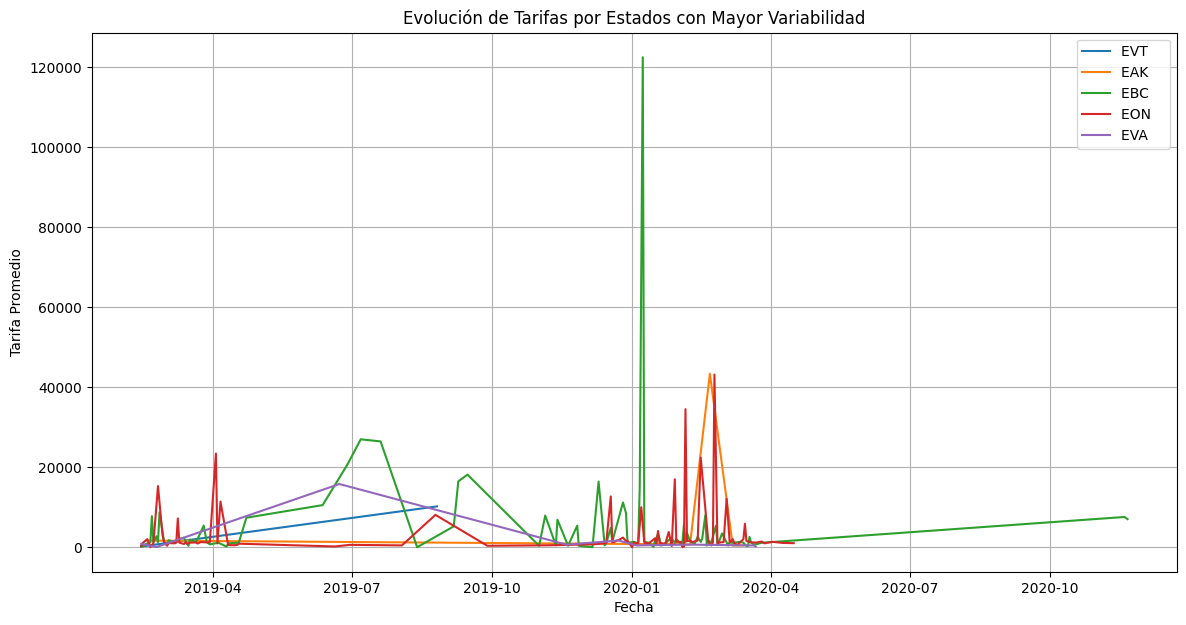

In [7]:
# Calcular variabilidad por estado
variabilidad_estados = iar_Reservaciones.groupby('h_edo')['h_tfa_total'].agg(['mean', 'std', 'count'])
variabilidad_estados['coef_variacion'] = variabilidad_estados['std'] / variabilidad_estados['mean']

# Estados con mayor variación relativa
top_estados = variabilidad_estados.sort_values('coef_variacion', ascending=False).head(5)

# Visualización por estados seleccionados
estados_seleccion = top_estados.index.tolist()
df_estados = iar_Reservaciones[iar_Reservaciones['h_edo'].isin(estados_seleccion)]

plt.figure(figsize=(14, 7))
for estado in estados_seleccion:
    datos_estado = df_estados[df_estados['h_edo'] == estado]
    datos_agrupados = datos_estado.groupby('h_fec_lld_okt')['h_tfa_total'].mean()
    plt.plot(datos_agrupados.index, datos_agrupados, label=estado)

plt.title('Evolución de Tarifas por Estados con Mayor Variabilidad')
plt.xlabel('Fecha')
plt.ylabel('Tarifa Promedio')
plt.legend()
plt.grid(True)
plt.show()

Como se puede mostrar en la gráfica, la evolución de tarifas con mayor variabilidad proviene de los siguientes estados:

EVT - Vermont
EAK - Alaska
EBC - British Columbia
EON - Ontario
EVA - Virginia

Siendo British Columbia el que más resalta de entre todas las variabilidades en tarifas de reservaciones a lo largo del tiempo.

## Serie Temporal

In [8]:
data = (
    iar_Reservaciones
    .groupby('h_fec_lld_okt')['h_tfa_total']
    .mean()
    .reset_index()
)

data.columns = ['Fecha', 'tarifa']
data

,Fecha,tarifa
0,2019-02-05,672.800000
1,2019-02-06,11052.000000
2,2019-02-12,18999.200000
3,2019-02-13,4702.505750
4,2019-02-14,4788.576467
...,...,...
708,2021-07-17,7444.990000
709,2021-07-24,6615.612500
710,2021-07-31,7640.010000
711,2021-08-07,6129.970000


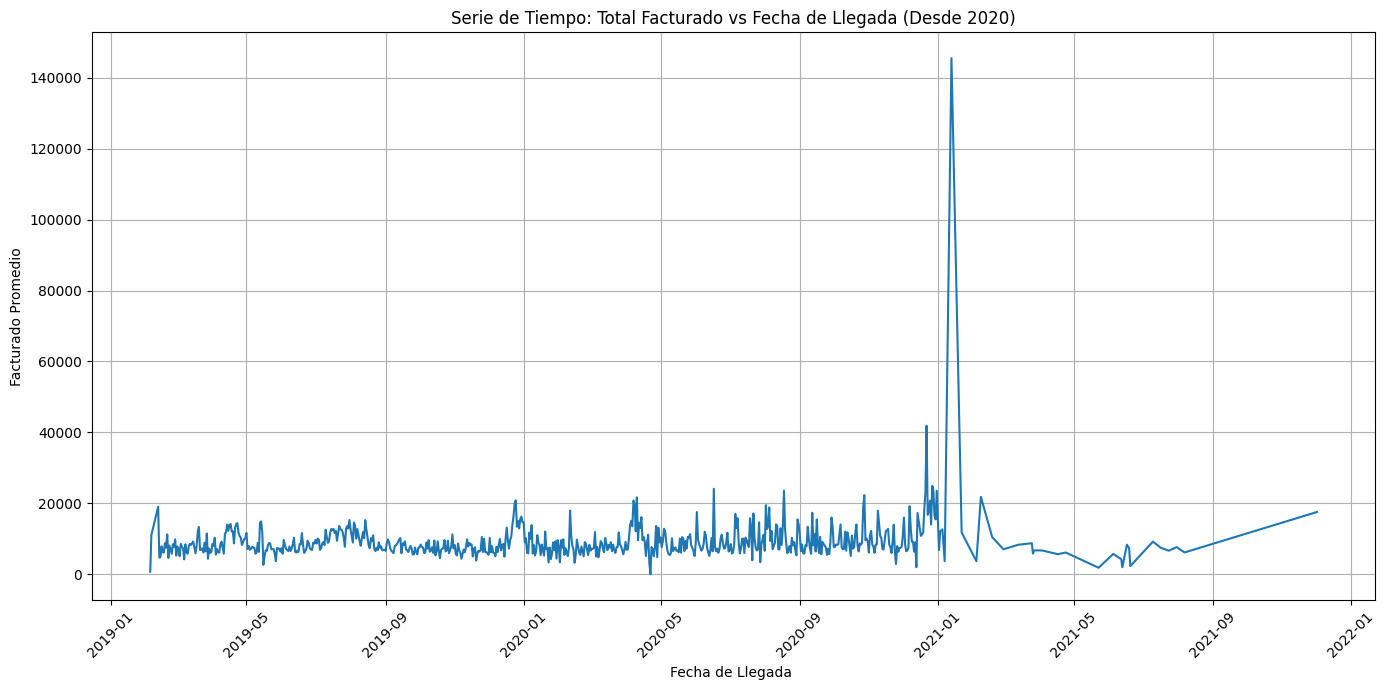

In [9]:
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=data,
    x='Fecha',
    y='tarifa'
)
plt.title('Serie de Tiempo: Total Facturado vs Fecha de Llegada (Desde 2020)')
plt.xlabel('Fecha de Llegada ')
plt.ylabel('Facturado Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

En cuanto a registro de datos, es posible ver un cambio abrupto a partir del 2020, sin embargo, se puede notar que a partir del 2021, el registro de datos ha sido irregular.

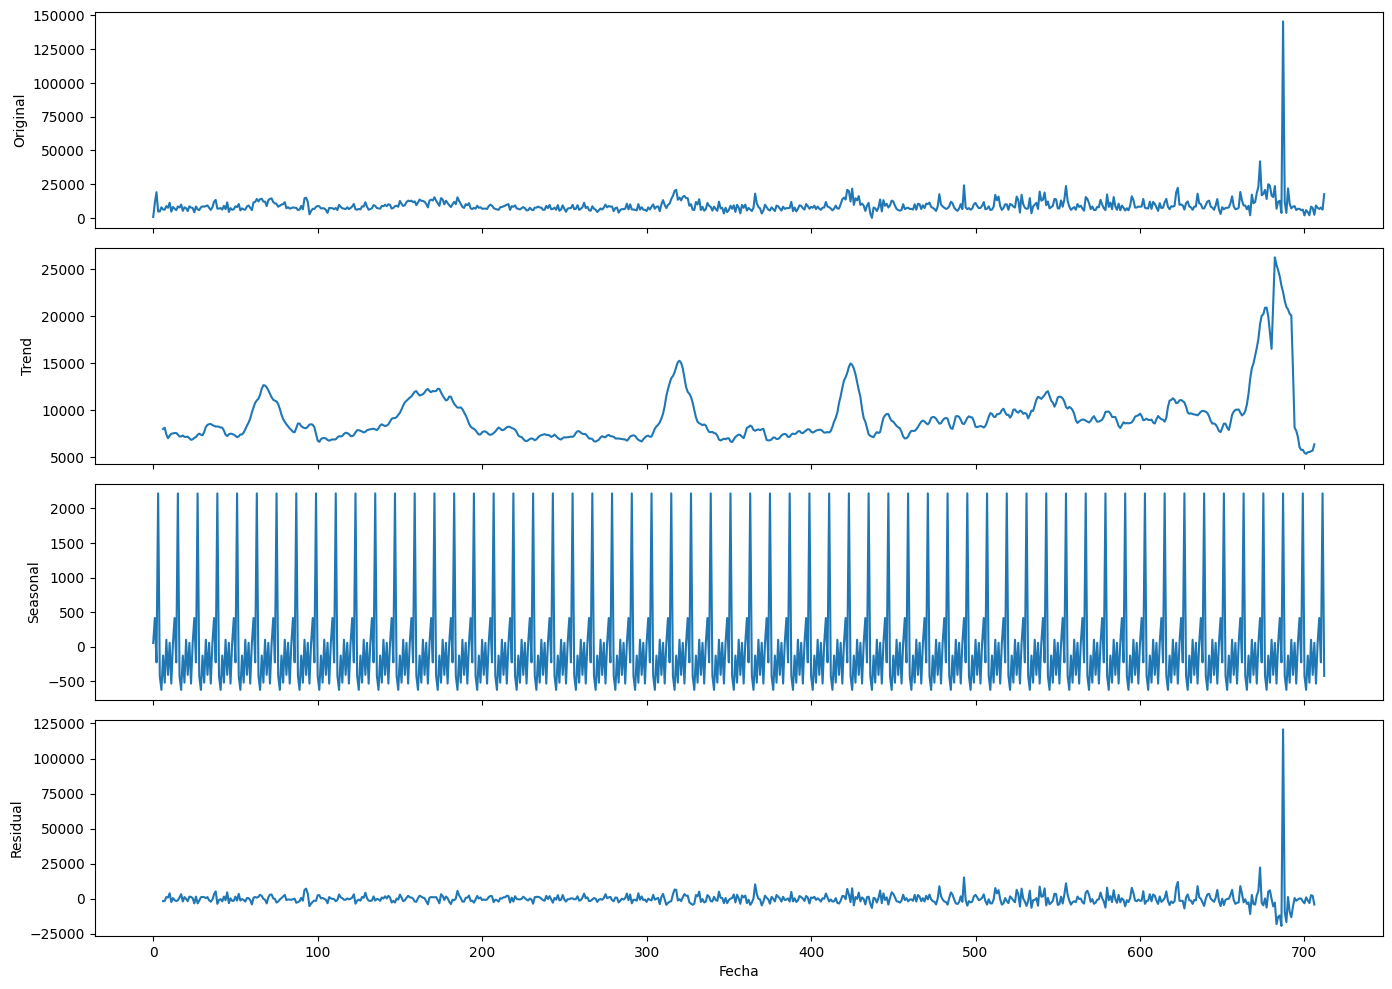

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(data["tarifa"], model='additive', period=12)  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Serie original
ax1.plot(result.observed)
ax1.set_ylabel('Original')

# Tendencia
ax2.plot(result.trend)
ax2.set_ylabel('Trend')

# Estacionalidad
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(result.resid)
ax4.set_ylabel('Residual')

plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

Aquí se puede ver en su totalidad la manera en la que se comporta la serie de tiempo en las siguientes categorías: original, tendencia, estacionalidad y residual. Es posible ver el cambio abrupto principalmente a finales de la serie.

## TDA

In [11]:
# Formato correcto de datos
df_combinado['h_fec_lld_okt'] = pd.to_datetime(df_combinado['h_fec_lld_okt'])

In [12]:
# Definir los segmentos temporales

fecha_min = df_combinado['h_fec_lld_okt'].min()
fecha_max = df_combinado['h_fec_lld_okt'].max()
segmentos = [
    ('Primer Tercio', fecha_min, fecha_min + (fecha_max - fecha_min)/3),
    ('Segundo Tercio', fecha_min + (fecha_max - fecha_min)/3, fecha_min + 2*(fecha_max - fecha_min)/3),
    ('Tercer Tercio', fecha_min + 2*(fecha_max - fecha_min)/3, fecha_max)
]


In [13]:
# Mostrar los segmentos 
print("\nSegmentos definidos para análisis:")
for i, (nombre, inicio, fin) in enumerate(segmentos, 1):
    print(f"{i}. {nombre}: {inicio.strftime('%Y-%m-%d')} a {fin.strftime('%Y-%m-%d')}")


Segmentos definidos para análisis:
1. Primer Tercio: 2019-02-05 a 2020-01-14
2. Segundo Tercio: 2020-01-14 a 2020-12-23
3. Tercer Tercio: 2020-12-23 a 2021-12-02


In [14]:
# Función de análisis TDA 
def analisis_tda_seguro(df, fecha_inicio, fecha_fin, nombre_segmento):

    segmento = df[(df['h_fec_lld_okt'] >= fecha_inicio) & 
                    (df['h_fec_lld_okt'] <= fecha_fin)].copy()
    
    signal = segmento.groupby('h_fec_lld_okt')['h_tfa_total'].mean()
    
        
    scaler = StandardScaler()
    signal_norm = scaler.fit_transform(signal.values.reshape(-1, 1)).flatten()
    
    # Función Takens Embedding
    def takensEmbedding(data, delay, dimension):
        """Implementación segura del embedding de Takens"""
        if (delay * (dimension - 1)) >= len(data):
            raise ValueError('Delay*(dimension-1) debe ser menor que el tamaño de los datos.')
        return np.column_stack([data[i*delay: len(data) - (delay * (dimension - i - 1))] 
                                for i in range(dimension)])
    
    embedded = takensEmbedding(signal_norm, delay=1, dimension=3)
    
    rips = gd.RipsComplex(points=embedded, max_edge_length=2.0)
    simplex = rips.create_simplex_tree(max_dimension=2)
    diag = simplex.persistence()
    
    # Visualización
    plt.figure(figsize=(12, 5))
    gd.plot_persistence_diagram(diag)
    plt.title(f'Diagrama de Persistencia - {nombre_segmento}\n{len(signal)} puntos')
    plt.show()
    
    return {
        'segmento': nombre_segmento,
        'betti0': len([x for x in diag if x[0] == 0]),
        'betti1': len([x for x in diag if x[0] == 1]),
        'persistencia_promedio': np.nanmean([x[1][1]-x[1][0] for x in diag if x[1][1] != float('inf')]),
        'puntos_analizados': len(signal)
    }
    



Analizando segmento: Primer Tercio...


/Users/abigail/miniconda3/lib/python3.12/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


<Figure size 1200x500 with 0 Axes>

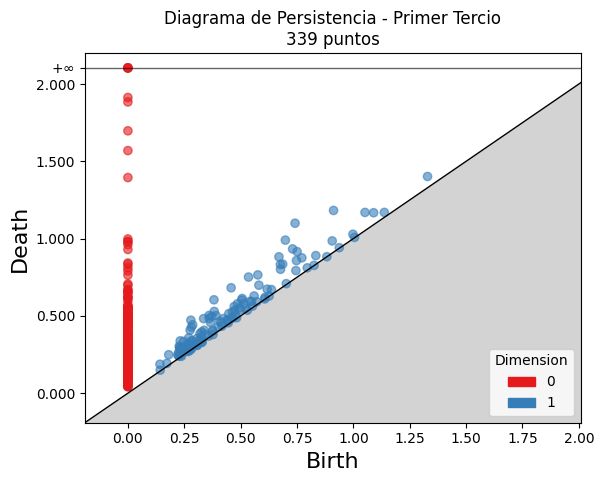


Analizando segmento: Segundo Tercio...


<Figure size 1200x500 with 0 Axes>

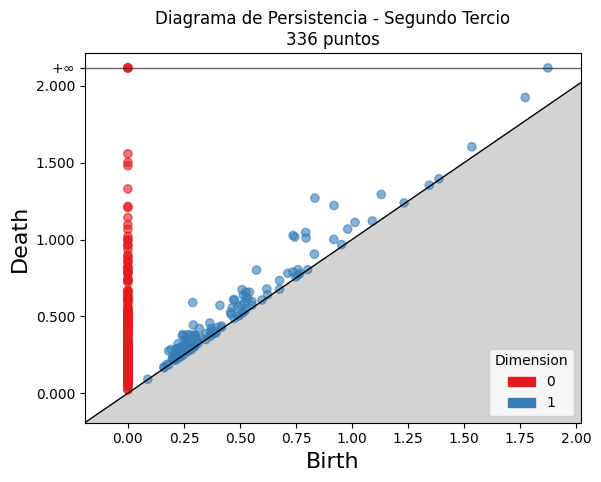


Analizando segmento: Tercer Tercio...


<Figure size 1200x500 with 0 Axes>

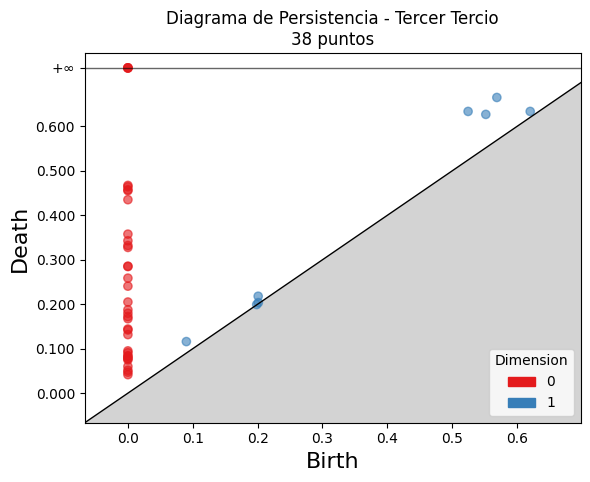

In [15]:
# Análisis para cada segmento
resultados = []
for nombre, inicio, fin in segmentos:
    print(f"\nAnalizando segmento: {nombre}...")
    res = analisis_tda_seguro(df_combinado, inicio, fin, nombre)
    if res:
        resultados.append(res)

In [16]:
# Mostrar resultados
if resultados:
    df_resultados = pd.DataFrame(resultados)
    print("\nResultados del análisis TDA por segmentos:")
    print(df_resultados[['segmento', 'puntos_analizados', 'betti0', 'betti1', 'persistencia_promedio']])
else:
    print("No se obtuvieron resultados válidos de ningún segmento.")


Resultados del análisis TDA por segmentos:
         segmento  puntos_analizados  betti0  betti1  persistencia_promedio
0   Primer Tercio                339     337     125               0.249559
1  Segundo Tercio                336     334     128               0.251979
2   Tercer Tercio                 38      36       8               0.179081


Los puntos analizados refieren a la cantidad de datos (días) analizados, por lo que se puede apreciar que efectivamente, hay pocos datos en 2021. Un alto número en B0 (330+) indica muchos puntos aislados inicialmente. En B1 indica estructuras cíclicas en la dinámica de tarifas, cantidad relativamente estable en primeros dos tercios y notable reducción en el tercer tercio. Y la Persistencia promedio mide duración promedio de las características topológicas: Mide cuánto persisten las estructuras a diferentes escalas, similar en primeros dos tercios (~0.25), menor en tercer tercio (0.18).

# Modelo Optimista

## Limpieza y Transformación de datos

In [17]:
iar_Reservaciones = pd.read_csv('Selected/iar_Reservaciones.csv')
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["aa_h_num_per"] == 0]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["h_tfa_total"] >= 0]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["h_tfa_total"] <= 200000]
iar_Reservaciones = iar_Reservaciones[[col for col in iar_Reservaciones.columns if not col.startswith("aa")]]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones['h_fec_lld_okt'] >= '2019-01-01']
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones['h_fec_lld_okt'] <= '2020-01-01']
iar_Reservaciones = iar_Reservaciones.sort_values('h_fec_lld_okt')
iar_Reservaciones = iar_Reservaciones.set_index('h_fec_lld_okt')
iar_Reservaciones.index = pd.to_datetime(iar_Reservaciones.index, errors='coerce')

/var/folders/p9/b03xf1dn2n34z0fr_cls9vz00000gp/T/ipykernel_62848/3858411186.py:1: DtypeWarning: Columns (22,28) have mixed types. Specify dtype option on import or set low_memory=False.
  iar_Reservaciones = pd.read_csv('Selected/iar_Reservaciones.csv')


## Obtención de Datos

Hacemos un nuevo registro de datos, donde se calcula la media de tarifas por cada día.

In [18]:
data = (
    iar_Reservaciones
    .groupby('h_fec_lld_okt')['h_tfa_total']
    .mean()
    .reset_index()
)

data.columns = ['Fecha', 'tarifa']
data

,Fecha,tarifa
0,2019-02-05,672.800000
1,2019-02-06,11052.000000
2,2019-02-12,18999.200000
3,2019-02-13,4702.505750
4,2019-02-14,4788.576467
...,...,...
320,2019-12-27,15034.176049
321,2019-12-28,12911.803546
322,2019-12-29,15648.286371
323,2019-12-30,16218.035503


## Serie de Tiempo 

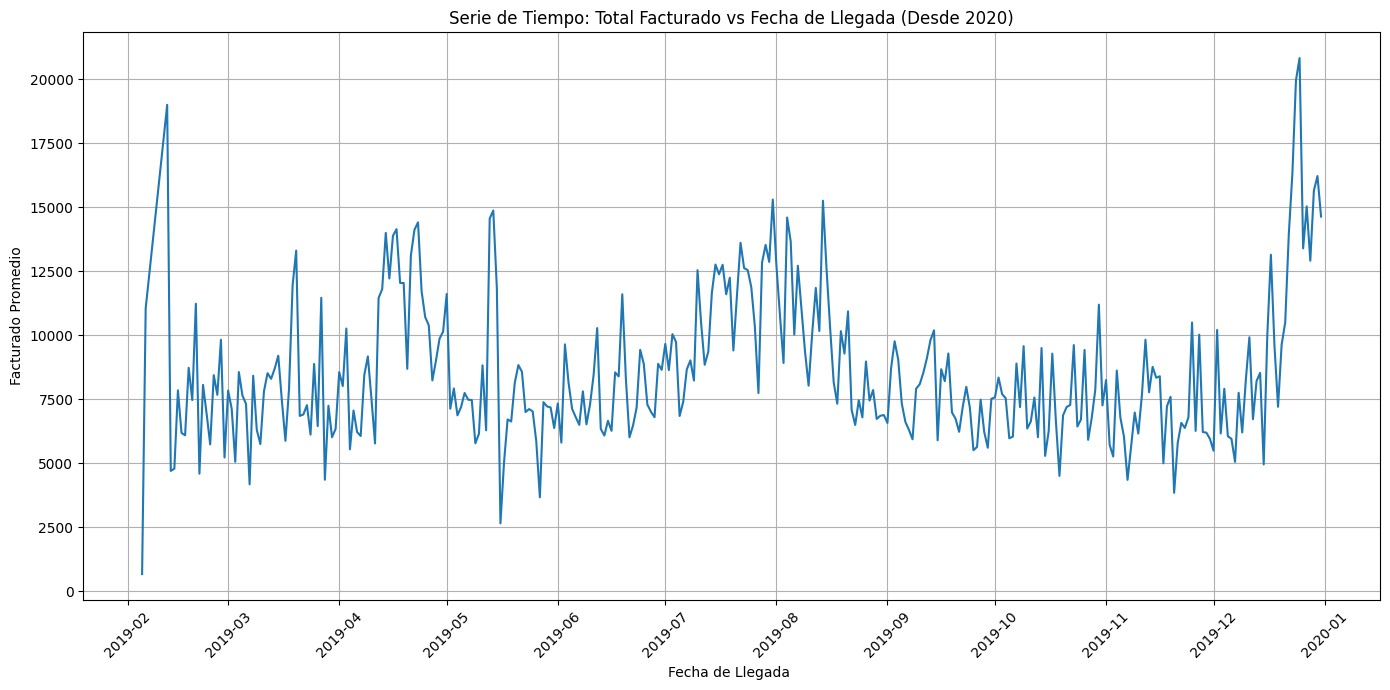

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=data,
    x='Fecha',
    y='tarifa'
)
plt.title('Serie de Tiempo: Total Facturado vs Fecha de Llegada (Desde 2020)')
plt.xlabel('Fecha de Llegada ')
plt.ylabel('Facturado Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Descomposición de Serie de Tiempo

Esto nos permitirá entender la composición y características de la línea temporal con respecto a la variable de tarifa.

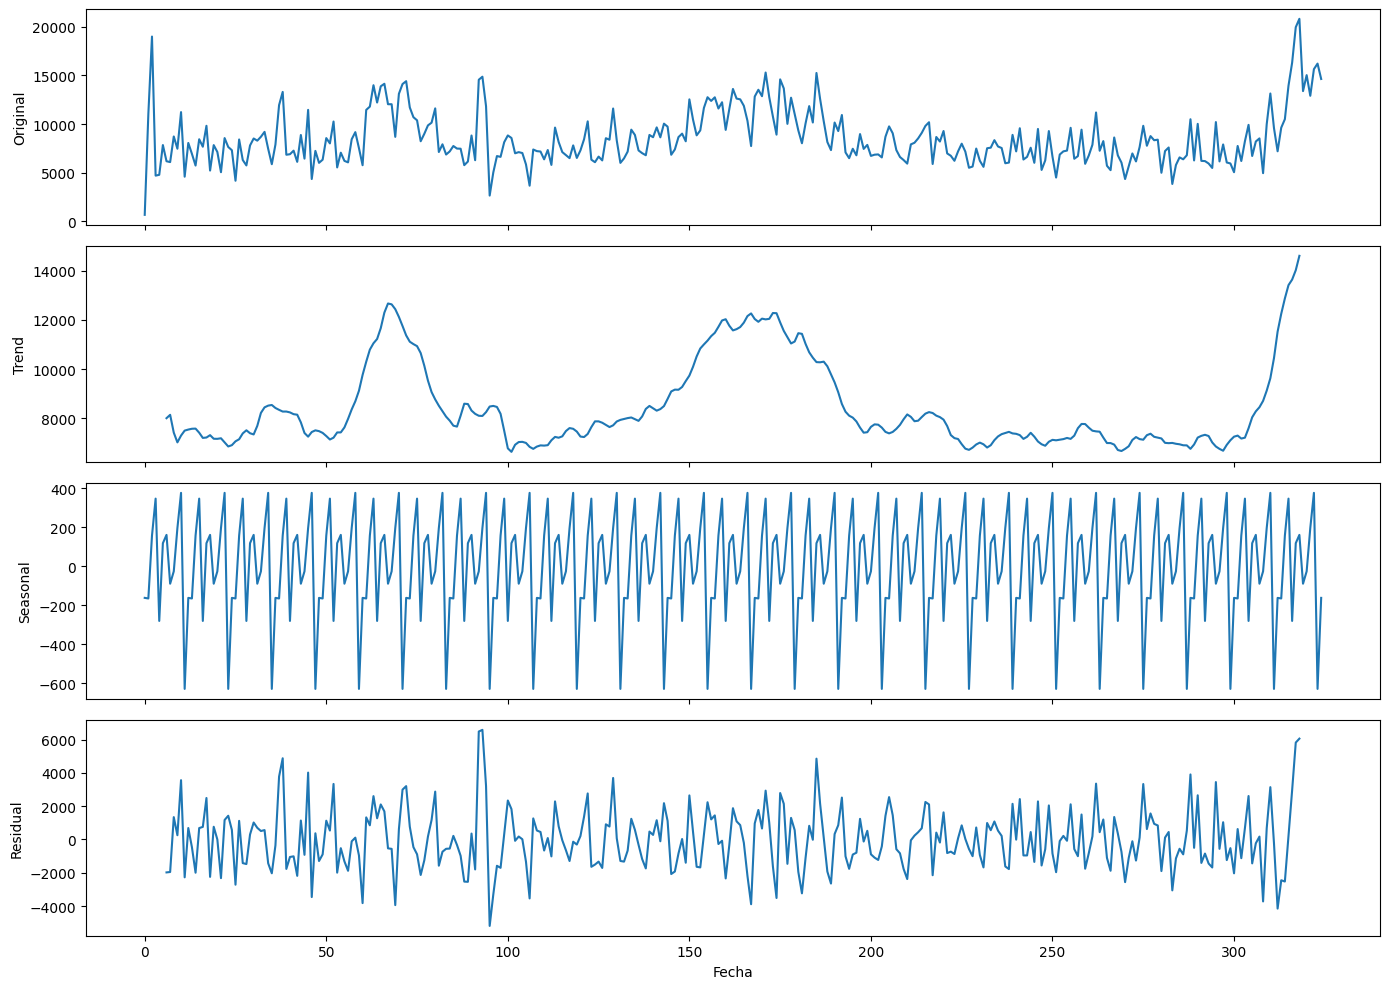

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(data["tarifa"], model='additive', period=12)  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Serie original
ax1.plot(result.observed)
ax1.set_ylabel('Original')

# Tendencia
ax2.plot(result.trend)
ax2.set_ylabel('Trend')

# Estacionalidad
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(result.resid)
ax4.set_ylabel('Residual')

plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

Tendencia:
Hay leves subidas en fechas estratégicas como en temporadas de semana santa, a mediados del año (verano) y a final del año.

Estacionalidad:
Se ve un patrón repetitivo bastante claro. Esto indica que la serie tiene ciclos diarios.

Residuos:
Se ven algunos saltos grandes, pero en general el residuo se mantiene relativamente estable.

## Realización del análisis topológico

Ya que vimos estas características, comprobemos como quedaría este análisis si escalamos los datos de tarifa promedio a otras dimensiones para ver la periodicidad de las tarifas con respecto a la temporada.

Aquí aplicamos la normalización de los datos de tarifa, para después aplicarla para el encaje de takens; técnica utilizada para reconstruir la dinámica de un sistema dinámico complejo, que sirve sobretodo para observar su periodicidad y entender su evolución temporal. 

In [21]:
from sklearn.preprocessing import StandardScaler
signal = data["tarifa"]
scaler = StandardScaler()
signal = scaler.fit_transform(signal.values.reshape(-1, 1)).flatten()

delay = 1
dimension = 3 

def takensEmbedding(data, delay, dimension):
    if (delay * (dimension - 1)) >= len(data):
        raise ValueError('Delay * (dimension-1) debe ser menor que el tamaño de los datos.')
    
    embedded_data = np.column_stack([data[i*delay: len(data) - (delay * (dimension - i - 1))] for i in range(dimension)])
    return embedded_data

embedded_signal = takensEmbedding(signal, delay, dimension)



## Visualización del Encaje de Takens en 2-D

In [22]:
import plotly.express as px
import pandas as pd

df_embedded = pd.DataFrame(embedded_signal, columns=[f'Dim_{i+1}' for i in range(embedded_signal.shape[1])])

fig = px.scatter(
    df_embedded,
    x='Dim_1',
    y='Dim_2',
    title='Encaje de Takens (2D)',
    labels={'Dim_1': 'Primera dimensión', 'Dim_2': 'Segunda dimensión'},
    opacity=0.7
)
fig.update_layout(width=700, height=500)
fig.show()

Podemos observar que existe cierta tendencia en cuanto al incremento de las tarifas, por lo que si hay un incremento de ingreso, se tiende a seguir incrementando. Visualmente podemos ver una correlación positiva entre su valor con el desfase (1).

## Visualización del Encaje de Takens en 3-D

In [23]:
df_embedded = pd.DataFrame(embedded_signal, columns=[f'Dim_{i+1}' for i in range(embedded_signal.shape[1])])
fig = px.scatter_3d(
    df_embedded,
    x='Dim_1',
    y='Dim_2',
    z='Dim_3',
    title='Encaje de Takens (3D)',
    labels={'Dim_1': 'Primera dimensión', 'Dim_2': 'Segunda dimensión', 'Dim_3': 'Tercera dimensión'},
    opacity=0.7
)
fig.update_layout(width=700, height=600)
fig.show()

## Diagrama de Persistencia

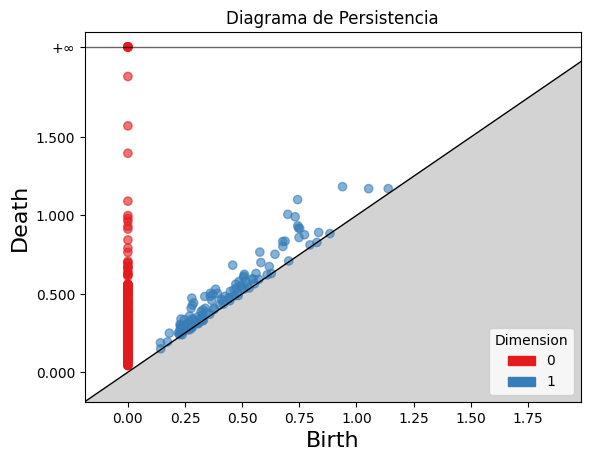

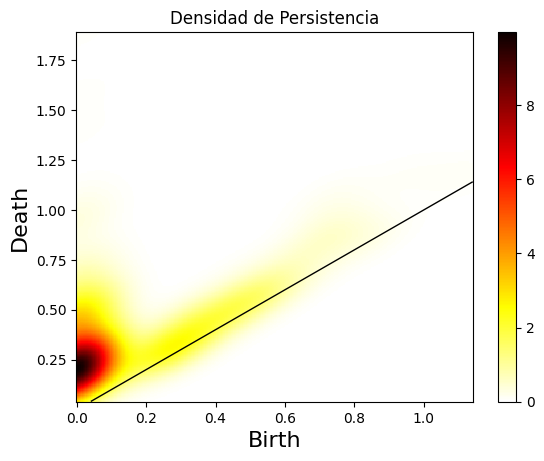

In [24]:
import gudhi as gd
import matplotlib.pyplot as plt

rips_complex = gd.RipsComplex(points=embedded_signal, max_edge_length=2.0)

simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

diag = simplex_tree.persistence()

gd.plot_persistence_diagram(diag)
plt.title('Diagrama de Persistencia')
plt.show()

gd.plot_persistence_density(diag)
plt.title('Densidad de Persistencia')
plt.show()



En el diagrama de persistencia, podemos observar lo siguiente.

- Betti 0: inicialmente hay muchas componentes desconectadas que rápidamente se van uniendo en una sola gran componente a medida que aumentas la escala. El hecho de que algunos lleguen hasta infinito sugiere que una componente principal permanece conectada todo el tiempo.

- Betti 1: Si hay pequeños ciclos en la forma de los datos, pero no son estructuras muy persistentes ni dominantes.

Adicionalmente, tenemos un diagrama de densidad que nos muestra de forma similar el comportamiento de los datos de tarifa, que al pricipio estos se van acumulando y tal como se pudo ver, existe una componente conexa. Pero estos datos no son lo suficientemente persistentes para predecir las tarifas puesto a que sus características de periodicidad no son lo suficientemente estables.  

# Modelo Pesimista

## Limpieza y Transformación de datos

In [25]:
iar_Reservaciones = pd.read_csv('Selected/iar_Reservaciones.csv')
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["aa_h_num_per"] == 0]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["h_tfa_total"] >= 0]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["h_tfa_total"] <= 200000]
iar_Reservaciones = iar_Reservaciones[[col for col in iar_Reservaciones.columns if not col.startswith("aa")]]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones['h_fec_lld_okt'] >= '2020-01-01']
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones['h_fec_lld_okt'] <= '2021-01-01']
iar_Reservaciones = iar_Reservaciones.sort_values('h_fec_lld_okt')
iar_Reservaciones = iar_Reservaciones.set_index('h_fec_lld_okt')
iar_Reservaciones.index = pd.to_datetime(iar_Reservaciones.index, errors='coerce')

/var/folders/p9/b03xf1dn2n34z0fr_cls9vz00000gp/T/ipykernel_62848/1888347723.py:1: DtypeWarning:

Columns (22,28) have mixed types. Specify dtype option on import or set low_memory=False.



## Obtención de Datos

Hacemos un nuevo registro de datos, donde se calcula la media de tarifas por cada día.

In [26]:
data = (
    iar_Reservaciones
    .groupby('h_fec_lld_okt')['h_tfa_total']
    .mean()
    .reset_index()
)

data.columns = ['Fecha', 'tarifa']
data

,Fecha,tarifa
0,2020-01-01,14577.532353
1,2020-01-02,8963.369487
2,2020-01-03,10127.365686
3,2020-01-04,6049.291907
4,2020-01-05,5857.404899
...,...,...
353,2020-12-27,24934.000000
354,2020-12-28,23768.346667
355,2020-12-29,16549.973438
356,2020-12-30,15450.481481


## Serie de Tiempo 

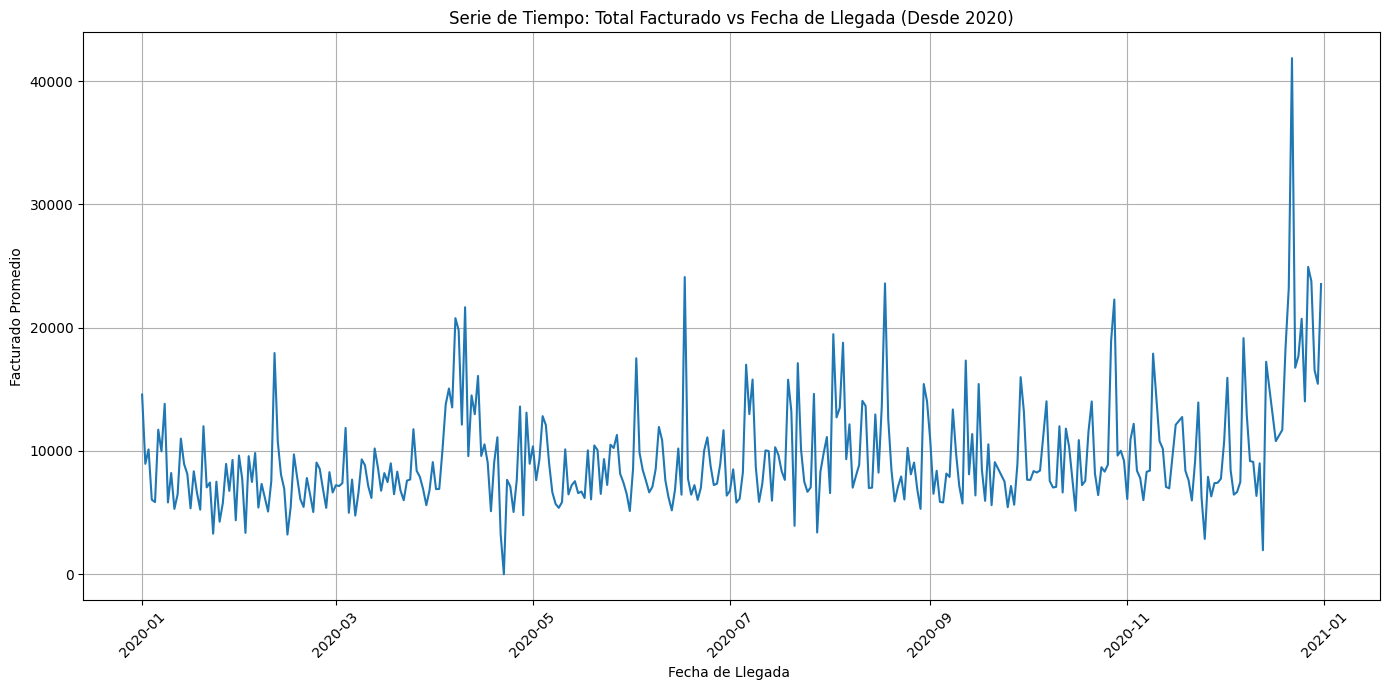

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=data,
    x='Fecha',
    y='tarifa'
)
plt.title('Serie de Tiempo: Total Facturado vs Fecha de Llegada (Desde 2020)')
plt.xlabel('Fecha de Llegada ')
plt.ylabel('Facturado Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Aquí se puede apreciar una gran variabilidad de datos durante la pandemia.

## Descomposición de Serie de Tiempo

Esto nos permitirá entender la composición y características de la línea temporal con respecto a la variable de tarifa.

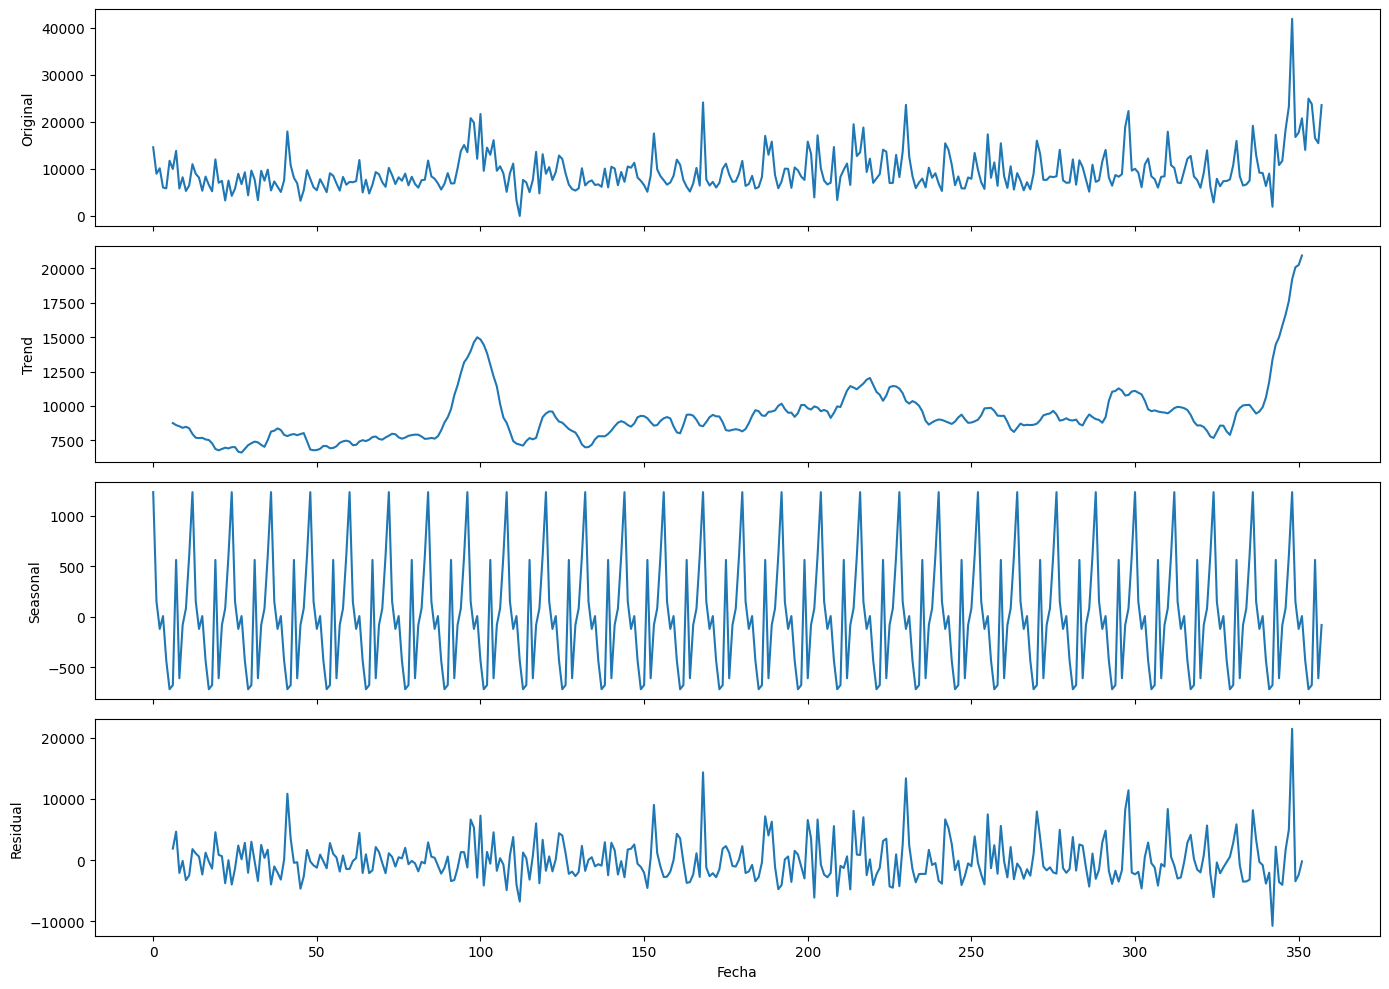

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(data["tarifa"], model='additive', period=12)  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Serie original
ax1.plot(result.observed)
ax1.set_ylabel('Original')

# Tendencia
ax2.plot(result.trend)
ax2.set_ylabel('Trend')

# Estacionalidad
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(result.resid)
ax4.set_ylabel('Residual')

plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

Aquí se puede ver en su totalidad la manera en la que se comporta la serie de tiempo en las siguientes categorías: original, tendencia, estacionalidad y residual. Es posible ver el cambio abrupto principalmente a finales de la serie.

## Realización del análisis topológico

Ya que vimos estas características, comprobemos como quedaría este análisis si escalamos los datos de tarifa promedio a otras dimensiones para ver la periodicidad de las tarifas con respecto a la temporada.

Aquí aplicamos la normalización de los datos de tarifa, para después aplicarla para el encaje de takens; técnica utilizada para reconstruir la dinámica de un sistema dinámico complejo, que sirve sobretodo para observar su periodicidad y entender su evolución temporal. 

In [29]:
from sklearn.preprocessing import StandardScaler
signal = data["tarifa"]
scaler = StandardScaler()
signal = scaler.fit_transform(signal.values.reshape(-1, 1)).flatten()

delay = 1
dimension = 3 

def takensEmbedding(data, delay, dimension):
    if (delay * (dimension - 1)) >= len(data):
        raise ValueError('Delay * (dimension-1) debe ser menor que el tamaño de los datos.')
    
    embedded_data = np.column_stack([data[i*delay: len(data) - (delay * (dimension - i - 1))] for i in range(dimension)])
    return embedded_data

embedded_signal = takensEmbedding(signal, delay, dimension)



## Visualización del Encaje de Takens en 2-D

In [30]:
import plotly.express as px
import pandas as pd

df_embedded = pd.DataFrame(embedded_signal, columns=[f'Dim_{i+1}' for i in range(embedded_signal.shape[1])])

fig = px.scatter(
    df_embedded,
    x='Dim_1',
    y='Dim_2',
    title='Encaje de Takens (2D)',
    labels={'Dim_1': 'Primera dimensión', 'Dim_2': 'Segunda dimensión'},
    opacity=0.7
)
fig.update_layout(width=700, height=500)
fig.show()

## Visualización del Encaje de Takens en 3-D

In [31]:
df_embedded = pd.DataFrame(embedded_signal, columns=[f'Dim_{i+1}' for i in range(embedded_signal.shape[1])])
fig = px.scatter_3d(
    df_embedded,
    x='Dim_1',
    y='Dim_2',
    z='Dim_3',
    title='Encaje de Takens (3D)',
    labels={'Dim_1': 'Primera dimensión', 'Dim_2': 'Segunda dimensión', 'Dim_3': 'Tercera dimensión'},
    opacity=0.7
)
fig.update_layout(width=700, height=600)
fig.show()

## Diagrama de Persistencia

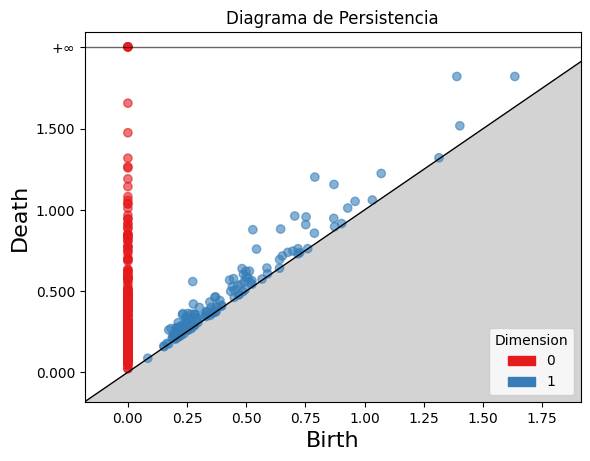

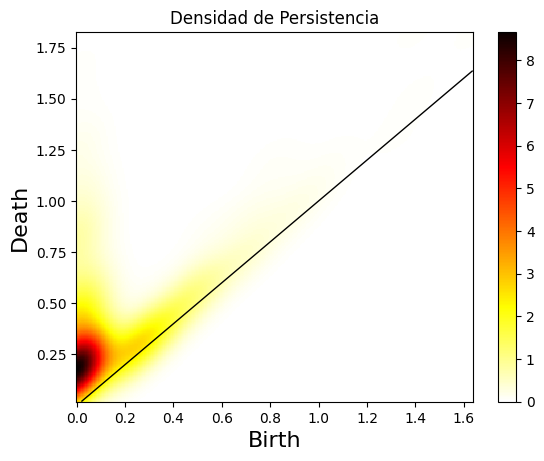

In [32]:
import gudhi as gd
import matplotlib.pyplot as plt

rips_complex = gd.RipsComplex(points=embedded_signal, max_edge_length=2.0)

simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

diag = simplex_tree.persistence()

gd.plot_persistence_diagram(diag)
plt.title('Diagrama de Persistencia')
plt.show()

gd.plot_persistence_density(diag)
plt.title('Densidad de Persistencia')
plt.show()



En el diagrama de persistencia, podemos observar lo siguiente.

- Betti 0: inicialmente hay muchas componentes desconectadas que rápidamente se van uniendo en una sola gran componente a medida que aumentas la escala. El hecho de que algunos lleguen hasta infinito sugiere que una componente principal permanece conectada todo el tiempo.

- Betti 1: Si hay pequeños ciclos en la forma de los datos, pero no son estructuras muy persistentes ni dominantes.

Adicionalmente, tenemos un diagrama de densidad que nos muestra de forma similar el comportamiento de los datos de tarifa, que al pricipio estos se van acumulando y tal como se pudo ver, existe una componente conexa. Pero estos datos no son lo suficientemente persistentes para predecir las tarifas puesto a que sus características de periodicidad no son lo suficientemente estables.  